In [105]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

from Forecasting import Forecast

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, LSTM, RNN

df = pd.read_pickle('Dados_SP.pkl')
df = df.sort_values(by='date')

In [103]:
class TimeObject:
    def __init__(self, df:pd.DataFrame, column:str, 
                 NAN_treatment_args:dict={'method':'nearest'}) -> None:

        self.df = df[['date',column]]
        self.column = column
        self.time_serie = self.to_serie()

        self.NAN_treatment(**NAN_treatment_args)
        self.NIXTLA_treatment()

    def to_serie(self) -> pd.Series:
        time_serie = self.df[self.column].fillna(np.nan)
        time_serie.index = pd.to_datetime(self.df['date'])

        full_index = pd.date_range(start=time_serie.index.min(), end=time_serie.index.max(), freq='D')
        time_serie = time_serie.reindex(full_index)
        return time_serie
    
    def NAN_treatment(self, **kwargs) -> None:
        self.time_serie = self.time_serie.interpolate(**kwargs)

    def plot(self) -> go.Figure:
        fig = go.Figure()
        fig.add_trace(trace=go.Scatter(
            x=self.time_serie.index, y=self.time_serie,
            marker=dict(color='#222222')
        ))
        return fig
    
    def NIXTLA_treatment(self) -> None:
        self.nixtla_df = pd.DataFrame()
        self.nixtla_df.loc[:, ['ds']] = pd.to_datetime(self.time_serie.index)
        self.nixtla_df.loc[:, ['y']] = self.time_serie.values
        self.nixtla_df.loc[:, ['unique_id']] = 1.0

In [110]:
obj = TimeObject(df=df, column='co',)
obj.time_serie

2014-01-01    5.0
2014-01-02    5.0
2014-01-03    5.0
2014-01-04    5.0
2014-01-05    5.0
             ... 
2024-11-14    1.0
2024-11-15    1.0
2024-11-16    1.0
2024-11-17    1.0
2024-11-18    NaN
Freq: D, Name: co, Length: 3975, dtype: float64

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.4 M  | train
----------------------------------------------------------
2.4 M     Trainable params
905       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `D

Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/gustavomeira/.pyenv/versions/3.12.0/lib/python3.12/site-packages/neuralforecast/core.py:210: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



[]

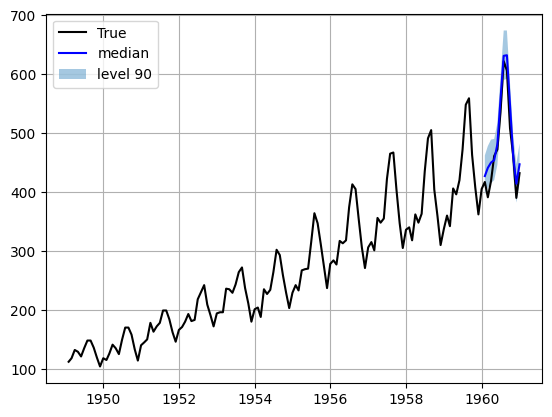

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NBEATS(h=12, input_size=24,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=100,
               val_check_steps=10,
               early_stop_patience_steps=2)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NBEATS-lo-90'][-12:].values, 
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()